# CS446/519 - Class Session 6 - Degree Distribution

In this class session we are going to plot the degree distribution of the undirected human
protein-protein interaction network (PPI), without using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder) and we'll 
manually compute the degree of each vertex (protein) in the network. We'll then compute
the count `N(k)` of vertices that have a given vertex degree `k`, for all `k` values.
Finally, we'll plot the degree distribution and discuss whether it is consistent with the 
results obtained in the Jeong et al. article for the yeast PPI.

Step 1:  load in the SIF file

In [1]:
sif_data <- read.table("shared/pathway_commons.sif",
                       sep="\t",
                       header=FALSE,
                       stringsAsFactors=FALSE,
                       col.names=c("species1",
                                   "interaction_type",
                                   "species2"),
                       quote="",
                       comment.char="")

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with")

In [2]:
interac_ppi <- sif_data[sif_data$interaction_type %in% c("in-complex-with",
                                                         "interacts-with"), c(1,3)]

Step 3: for each interaction, reorder `species1` and `species2` (if necessary) so that
`species1 < species2` (in terms of the species names, in lexicographic order)

In [3]:
interac_ppi_ordered <- data.frame(species1=interac_ppi[cbind(1:nrow(interac_ppi),
                                               ifelse(interac_ppi$species1 < interac_ppi$species2,
                                                      1, 2))],
                                  species2=interac_ppi[cbind(1:nrow(interac_ppi),
                                               ifelse(interac_ppi$species1 < interac_ppi$species2,
                                                      2, 1))],
                                  stringsAsFactors=FALSE)

Step 4: get only the unique interaction pairs of proteins (ignoring the interaction type)

In [4]:
interac_ppi_unique <- unique(interac_ppi_ordered)

Step 5: compute the degree of each vertex (though we will not associate the vertex degrees with vertex names here, since for this exercise we only need the vector of vertex degree values, not the associated vertex IDs)

In [5]:
vertex_degrees <- rle(sort(c(interac_ppi_unique$species1,
                             interac_ppi_unique$species2)))$lengths

Step 6: Calculate the histogram of N(k) vs. k, "suggesting" 30 bin "breaks" (i.e., bin edges) to R; `hist` will actually pick a different number of bins based on its own histogramming algorithm, so we'll find out exactly how many bin breaks that `hist` picked and then we'll call it `nbreaks_actual`, and we'll work with that. 

In [6]:
nbreaks <- 30
hist_res <- hist(vertex_degrees, plot=FALSE, nclass=nbreaks)
hist_counts <- hist_res$counts
hist_breaks <- hist_res$breaks
nbreaks_actual <- length(hist_breaks)
kvals <- (hist_breaks[1:(nbreaks_actual-1)] + hist_breaks[-1])/2

Step 7: Plot `N(k)` vs. `k`, on log-log scale (using only the first 14 points, which is plenty sufficient to see the approximatey scale-free degree distribution and where it becomes exponentially suppressed at high `k`.

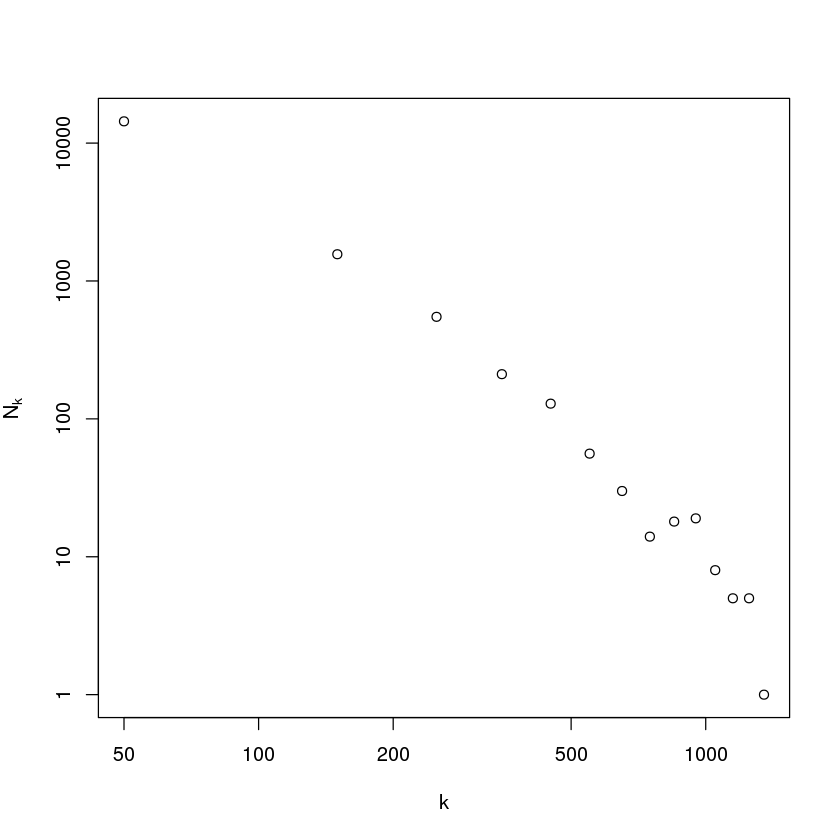

In [7]:
plot(kvals[1:14],
     hist_counts[1:14],
     type="p",
     main="",
     log="xy",
     xlab=expression(k),
     ylab=expression(N[k]))

Step 8:  Do a linear fit to the log10(N(k)) vs. log10(k) data (just over the range in which the relationship appears to be linear, which is the first five poitns)

In [16]:
# put the data from the linear range, into a data frame 
degdist_df <- data.frame(log10Nk=log10(hist_counts[1:5]),
                         log10k=log10(kvals[1:5]))

# linear regression
summary(lm(log10Nk ~ log10k, 
           data=degdist_df))


Call:
lm(formula = log10Nk ~ log10k, data = degdist_df)

Residuals:
       1        2        3        4        5 
-0.02811  0.03484  0.05842 -0.04317 -0.02197 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.84266    0.15619   50.21 1.74e-05 ***
log10k      -2.15214    0.06736  -31.95 6.74e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05087 on 3 degrees of freedom
Multiple R-squared:  0.9971,	Adjusted R-squared:  0.9961 
F-statistic:  1021 on 1 and 3 DF,  p-value: 6.738e-05


Slope is -2.15 with SE 0.16, i.e., gamma = 2.15 with a 95% CI of about +/- 0.32.

Now let's compute the slope for the degree distribution Fig. 1b in the Jeong et al. article, for the yeast PPI.  The change in ordinate over the linear range is about -6.5 in units of natural logarithm. The change in abscissa over the linear range is approximately log(45)-log(2), so we can compute the Jeong et al. slope thus:

In [17]:
round(-6.5/(log(45)-log(2)), digits=2)

[1] -2.09

That's pretty close to the human PPI slope!